# Adversarial Machine Learning

In this example, we show how to use Gurobi Machine Learning to construct an
adversarial example for a trained neural network.

We use the MNIST handwritten digit database (http://yann.lecun.com/exdb/mnist/)
for this example.

For this problem, we are given a trained neural network and one well classified
example $\bar x$. Our goal is to construct another example $x$ _close to_ $\bar
x$ that is classified with a different label.

For the hand digit recognition problem, the input is a grayscale image of $28
\times 28$ ($=784$) pixels and the output is a vector of length 10 (each entry
corresponding to a digit). We denote the output vector by $y$. The image is
classified according to the largest entry of $y$.

For the training example, assume that coordinate $l$ of the output vector is
the one with the largest value giving the correct label. We pick a coordinate
corresponding to another label, denoted $w$, and we want the difference between
$y_w - y_l$ to be as large as possible.

If we can find a solution where this difference is positive, then $x$ is a
_counter-example_ receiving a different label. If instead we can show that
the difference is never positive, no such example exists.

Here, we use the $l1-$norm $|| x - \bar x||_1$ to define the neighborhood with its size
defined by a fixed parameter $\delta$:

$$ || x - \bar x ||_1 \le \delta. $$

Denoting by $g$ the prediction function of the neural network, the full
optimization model reads:

$$ \begin{aligned} &\max y_w - y_l \\
&\text{subject to:}\\
&|| x - \bar x ||_1 \le \delta,\\
& y = g(x). \end{aligned} $$


Note that our model is inspired by <cite data-cite="fischetti_jo_2018">Fischet al.
(2018)</cite>.

## Imports and loading data

First, we import the required packages for this example.

In addition to the usual packages, we will need `matplotlib` to plot the digits,
and `joblib` to load a pre-trained network and part of the training data.

Note that from the `gurobi_ml` package we need to use directly the
`add_mlp_regressor_constr` function for reasons that will be clarified later.

In [1]:
import gurobipy as gp
import numpy as np
from joblib import load
from matplotlib import pyplot as plt

from gurobi_ml.sklearn import add_mlp_regressor_constr

We load a neural network that was pre-trained with Scikit-learn's MLPRegressor.
The network is small (2 hidden layers of 50 neurons), finding a counter
example shouldn't be too difficult.

We also load the first 100 training examples of the MNIST dataset that we saved
to avoid having to reload the full data set.

In [2]:
# Load the trained network and the examples
mnist_data = load("../../../tests/predictors/mnist__mlpclassifier.joblib")
nn = mnist_data["predictor"]
X = mnist_data["data"]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Choose an example and set labels

Now we choose an example. Here we chose arbitrarily example 26. We plot the
example and verify if it is well predicted by calling the `predict` function.

Predicted label ['4']


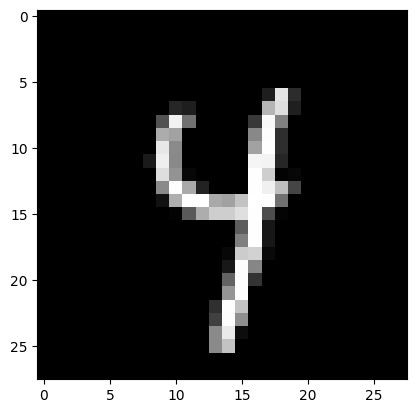

In [3]:
# Choose an example
exampleno = 26
example = X[exampleno : exampleno + 1, :]

plt.imshow(example.reshape((28, 28)), cmap="gray")

print(f"Predicted label {nn.predict(example)}")

To set up the objective function of the optimization model, we also need to find a
wrong label.

We use `predict_proba` to get the weight given by the neural
network to each label.
We then use `numpy`'s `argsort` function to get the labels sorted by
their weight. The right label is then the last element in the list, and we pick
the next to last element as the wrong label.

In [4]:
ex_prob = nn.predict_proba(example)
sorted_labels = np.argsort(ex_prob)[0]
right_label = sorted_labels[-1]
wrong_label = sorted_labels[-2]

## Building the optimization model

Now all the data is gathered, and we proceed to building the optimization
model.

We create a matrix variable `x` corresponding to the new input of the
neural network we want to compute and a `y` matrix variable for the output of the
neural network. Those variables should have respectively the shape of the
example we picked and the shape of the return value of `predict_proba`.

We need additional variables to model the $l1-$norm constraint. Namely, for
each pixel in the image, we need to measure the absolute difference between $x$
and $\bar x$. The corresponding matrix variable has the same shape as `x`.

We set the objective which is to maximize the difference between the
_wrong_ label and the _right_ label.

In [5]:
m = gp.Model()
delta = 5

x = m.addMVar(example.shape, lb=0.0, ub=1.0, name="x")
y = m.addMVar(ex_prob.shape, lb=-gp.GRB.INFINITY, name="y")

abs_diff = m.addMVar(example.shape, lb=0, ub=1, name="abs_diff")

m.setObjective(y[0, wrong_label] - y[0, right_label], gp.GRB.MAXIMIZE)

The $l1-$norm constraint is formulated with:

$$ \eta \ge x - \bar x \\
\eta \ge \bar x - x \\
\sum \eta \le \delta $$

With $\eta$ denoting the `absdiff` variables.

Those constraints are naturally expressed with Gurobi's Matrix API.

In [6]:
# Bound on the distance to example in norm-1
m.addConstr(abs_diff >= x - example)
m.addConstr(abs_diff >= -x + example)
m.addConstr(abs_diff.sum() <= delta)

# Update the model
m.update()

Finally, we insert the neural network in the `gurobipy` model to link `x` and
`y`.

Note that this case is not as straightforward as others. The reason is that the
neural network is trained for classification with a `"softmax"` activation in
the last layer. But in this model we are using the network without activation in
the last layer.

For this reason, we change manually the last layer activation before adding the
network to the Gurobi model.

Also, we use the function
[add_mlp_regressor_constr](../api/MlpRegressorConstr.rst#gurobi_ml.sklearn.add_mlp_regressor_constr)
directly. The network being actually for classification (i.e. of type
`MLPClassifier`) the
[add_predictor_constr](../api/AbstractPredictorConstr.rst#gurobi_ml.add_predictor_constr)
function would not handle it automatically.

In the output, there is a warning about adding constraints with
very small coefficients that are ignored. Neural-networks often contain very
small coefficients in their expressions. Any coefficient with an absolute value
smaller than $10^{-13}$ is ignored by Gurobi. This may result in slightly
different predicted values but should be negligible.

In [7]:
# Change last layer activation to identity
nn.out_activation_ = "identity"
# Code to add the neural network to the constraints
pred_constr = add_mlp_regressor_constr(m, nn, x, y)

# Restore activation
nn.out_activation_ = "softmax"

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


The model should be complete. We print the statistics of what was added to
insert the neural network into the optimization model.

In [8]:
pred_constr.print_stats()

Model for mlpclassifier:
200 variables
110 constraints
100 general constraints
Input has shape (1, 784)
Output has shape (1, 10)

--------------------------------------------------------------------------------
Layer           Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
dense                (1, 50)          100           50            0           50 (relu)

dense0               (1, 50)          100           50            0           50 (relu)

dense1               (1, 10)            0           10            0            0

--------------------------------------------------------------------------------


## Solving the model

We now turn to solving the optimization model. Solving the adversarial problem,
as we formulated it above, doesn't actually require computing a provably optimal
solution. Instead, we need to either:

   - find a feasible solution with a positive objective cost (i.e. a
     counter-example), or
   - prove that there is no solution of positive cost (i.e. no counter-example
     in the neighborhood exists).

 We can use Gurobi parameters to limit the optimization to answer those
 questions: setting
 [BestObjStop](https://www.gurobi.com/documentation/current/refman/bestobjstop.html#parameter:BestObjStop)
 to 0.0 will stop the optimizer if a counter-example is found, setting
 [BestBdStop](https://www.gurobi.com/documentation/current/refman/bestobjstop.html#parameter:BestBdStop)
 to 0.0 will stop the optimization if the optimizer has shown there is no
 counter-example.

We set the two parameters and optimize.

In [9]:
m.Params.BestBdStop = 0.0
m.Params.BestObjStop = 0.0
m.optimize()

Set parameter BestBdStop to value 0
Set parameter BestObjStop to value 0
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1679 rows, 1778 columns and 41554 nonzeros
Model fingerprint: 0xc22d8ee1
Model has 100 general constraints
Variable types: 1778 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-13, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 5e+00]
Presolve removed 1249 rows and 734 columns
Presolve time: 0.15s
Presolved: 430 rows, 1044 columns, 37839 nonzeros
Variable types: 964 continuous, 80 integer (74 binary)

Root relaxation: objective 2.466185e+03, 290 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   

## Add bounds on layer output of layer 1

This is for illustration purposes to show it can be done

Layers are stored in pred_constr._layers
Get the first one

In [10]:
layer1 = pred_constr._layers[1]

Each layer is a gurobi-ml modeling object with input variable and output variable

Neurons are in the same order as in the input model

We can inspect the values of the output variables for layer 1

In [11]:
layer1.output.X

array([[5.55137772, 0.        , 1.74980532, 2.92347031, 0.        ,
        2.67476248, 1.97397182, 6.54245705, 4.90730804, 0.        ,
        0.        , 0.        , 5.10787643, 7.23935975, 0.53321964,
        1.46823224, 6.87311717, 4.51794409, 0.20075533, 4.0813167 ,
        1.84748906, 0.        , 0.        , 1.60033324, 0.        ,
        0.        , 2.37030709, 0.        , 4.21258118, 0.        ,
        2.19811885, 4.77706862, 0.        , 6.11041105, 4.79996921,
        1.10245646, 6.15846024, 0.        , 0.92179975, 2.42432975,
        0.        , 2.28254179, 0.        , 3.94971873, 0.63625196,
        4.70129353, 0.        , 0.        , 4.98606993, 4.17447252]])

We can bound the output of each neurons of the layers by using gurobipy

In [12]:
# We bound it to 5 (arbitrarily but the solution should change because some values are bigger)
layer1.output.UB = 5.0

In [13]:
# Resolve the model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1679 rows, 1778 columns and 41554 nonzeros
Model fingerprint: 0x549ea09e
Model has 100 general constraints
Variable types: 1778 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e-13, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [2e-03, 5e+00]

MIP start from previous solve produced solution with objective 0.209254 (2.77s)
Loaded MIP start from previous solve with objective 0.209254
Processed MIP start in 3.91 seconds (4.76 work units)

Presolve removed 1249 rows and 734 columns
Presolve time: 0.16s
Presolved: 430 rows, 1044 columns, 37839 nonzeros
Variable types: 964 continuous, 80 integer (74 binary)

Explored 0 nodes (0 simplex iterations) in 4.09 seconds (4.84 work units)
Thread count was 8 (of

In [14]:
# Look at the values of the output in layer 1 again
layer1.output.X

array([[3.22200679e+00, 1.79724531e+00, 3.98144826e+00, 2.59451058e+00,
        7.03603842e-15, 2.88431685e+00, 1.64968163e+00, 5.00000000e+00,
        3.50998721e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.52474741e+00, 4.61855439e+00, 0.00000000e+00, 0.00000000e+00,
        5.00000000e+00, 3.20964507e+00, 5.37977582e-01, 3.18439920e+00,
        1.56851381e+00, 0.00000000e+00, 1.59307583e-01, 2.17111318e-03,
        1.96768704e+00, 2.53936520e+00, 4.36735775e+00, 1.96091010e+00,
        2.58402228e+00, 1.14046409e-01, 2.40920574e+00, 3.50710748e+00,
        0.00000000e+00, 5.00000000e+00, 4.24317275e+00, 9.64775859e-01,
        4.92503087e+00, 0.00000000e+00, 2.64769628e+00, 3.89514011e+00,
        0.00000000e+00, 1.89467832e+00, 0.00000000e+00, 1.19202605e+00,
        4.40478246e-01, 2.43967482e+00, 0.00000000e+00, 0.00000000e+00,
        4.72473658e+00, 1.90492454e+00]])

## Results

Normally, for the example and $\delta$ we chose, a counter example that gets the
wrong label is found. We finish this notebook by plotting the counter example
and printing how it is classified by the neural network.

Solution is classified as ['9']


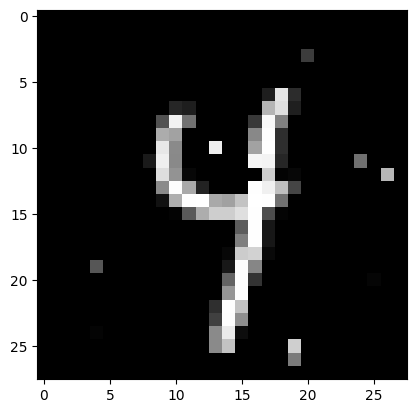

In [15]:
plt.imshow(x.X.reshape((28, 28)), cmap="gray")

print(f"Solution is classified as {nn.predict(x.X)}")

Copyright © 2023 Gurobi Optimization, LLC